In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import torch
import torch.nn as nn
import numpy as np
import cv2
from sklearn.preprocessing import scale, StandardScaler

In [4]:
#Data reading and splitting.
mnist_data = pd.read_csv('mnist.csv').values
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]
ink = np.array([sum(row) for row in digits])

#random_state ensures that the split data is the same for each program iteration.
x_train, x_test, y_train, y_test = train_test_split(digits, labels, test_size=0.88, random_state=42)
len(x_train), len(x_test)

(5040, 36960)

In [8]:
mnist_df = pd.read_csv('mnist.csv')

def get_constant_columns(df):
    constant_columns = []
    for column in df.columns:
        if df[column].nunique() == 1:
            constant_columns.append(column)
    return constant_columns

constant_columns = get_constant_columns(mnist_df)
print(constant_columns)

['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel82', 'pixel83', 'pixel84', 'pixel85', 'pixel111', 'pixel112', 'pixel139', 'pixel140', 'pixel141', 'pixel168', 'pixel196', 'pixel392', 'pixel420', 'pixel421', 'pixel448', 'pixel476', 'pixel532', 'pixel560', 'pixel644', 'pixel645', 'pixel671', 'pixel672', 'pixel673', 'pixel699', 'pixel700', 'pixel701', 'pixel727', 'pixel728', 'pixel729', 'pixel730', 'pixel731', 'pixel754', 'pixel755', 'pixel756', 'pixel757', 'pixel758', 'pixel759', 'pixel760', 'pixel780', 'pixel781', 'pixel782', 'pixel783']


In [9]:
print(len(constant_columns))

76


# EDA

C:\Users\Efraim\AppData\Local\Temp\ipykernel_16892\2394101854.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(0, 10)), y=label_counts, palette='Set2')


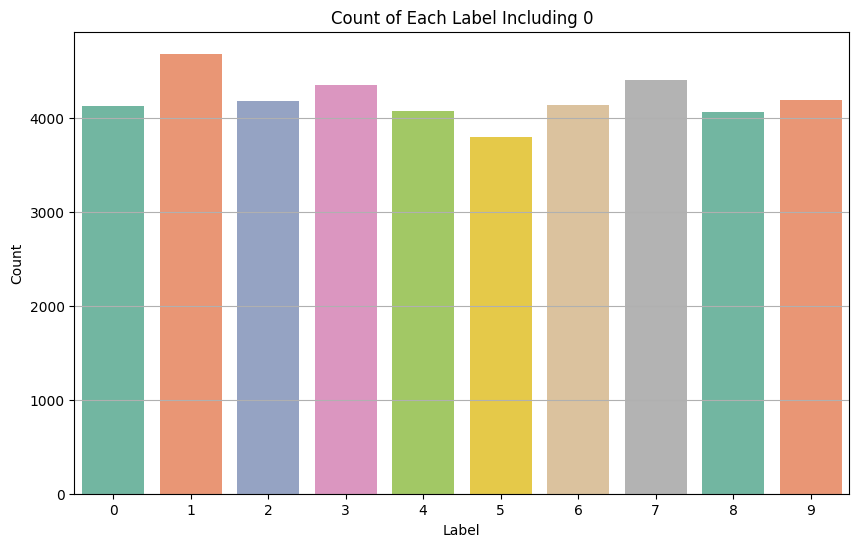


As we can see the classes in dataset are rather balanced, therefore if we use the majority class as a prediction (in our case it is 1),
the accuracy of resulting classifier will be 0.1115


In [5]:
label_counts = np.bincount(labels.astype('int'), minlength=10)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(0, 10)), y=label_counts, palette='Set2')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of Each Label Including 0')
plt.xticks(range(0, 10))
plt.grid(axis='y')
plt.show()

print(f"\nAs we can see the classes in dataset are rather balanced, therefore if we use the majority class as a prediction (in our case it is {label_counts.argmax()}),")
print(f"the accuracy of resulting classifier will be {np.round(label_counts.max()/len(labels), 4)}")

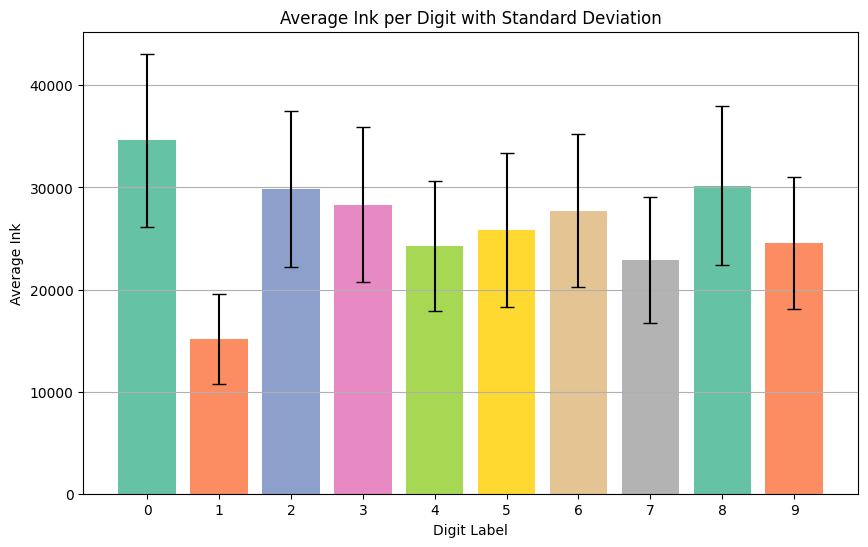

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
average_ink = np.zeros(10)
std_deviation = np.zeros(10)

# Calculate average ink and standard deviation for each digit
for i in range(10):
    digit_ink = ink[labels == i]
    average_ink[i] = np.mean(digit_ink)
    std_deviation[i] = np.std(digit_ink)

palette = sns.color_palette("Set2", 10)

plt.figure(figsize=(10, 6))
bars = plt.bar(np.arange(10), average_ink, color=palette, yerr=std_deviation, capsize=5)
plt.xlabel('Digit Label')
plt.ylabel('Average Ink')
plt.title('Average Ink per Digit with Standard Deviation')
plt.xticks(np.arange(10))
plt.grid(axis='y')
plt.show()

As we can see the ink feature isn't descriptive enough to efficiently differentiate all 10 classes. Some classes like 0 and 1 are perfectly separatable via this feature, however in general case, due to high high standard deviation, amount of ink for most classes heavily overlap, thus making it not a very strong feature on its own.

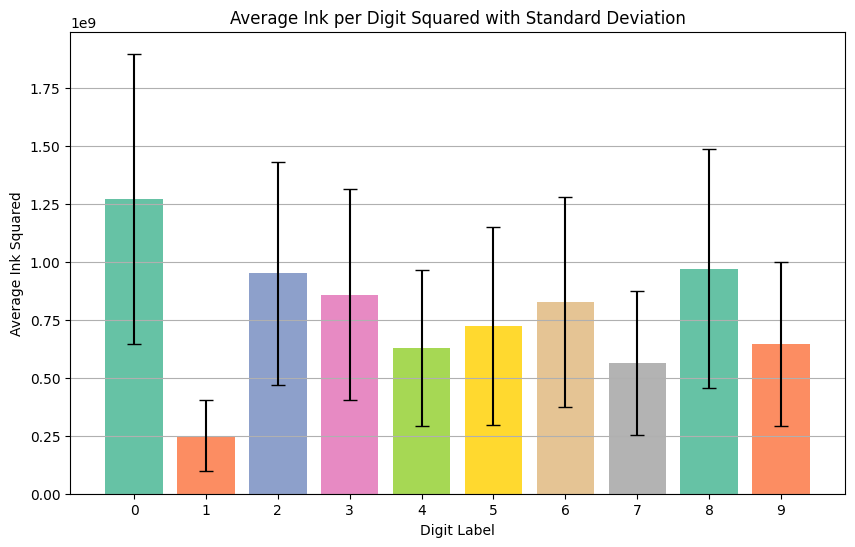

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
average_ink_2 = np.zeros(10)
std_deviation_2 = np.zeros(10)

# Calculate average ink and standard deviation for each digit
for i in range(10):
    digit_ink_sq = ink[labels == i]**2
    average_ink_2[i] = np.mean(digit_ink_sq)
    std_deviation_2[i] = np.std(digit_ink_sq)

palette = sns.color_palette("Set2", 10)

plt.figure(figsize=(10, 6))
bars = plt.bar(np.arange(10), average_ink_2, color=palette, yerr=std_deviation_2, capsize=5)
plt.xlabel('Digit Label')
plt.ylabel('Average Ink Squared')
plt.title('Average Ink per Digit Squared with Standard Deviation')
plt.xticks(np.arange(10))
plt.grid(axis='y')
plt.show()

Situation with ink**2 is similar due to huge std deviation.

# Hand crafted features experiments

In [8]:
def count_loops_with_blobs(flat_image):
    image_2d = flat_image.reshape((28, 28)).astype(np.uint8)
    detector = cv2.SimpleBlobDetector_create()

    # Detect blobs in the image
    keypoints = detector.detect(image_2d)
    return len(keypoints)


scaler = StandardScaler()
custom_train = pd.DataFrame(data={'ink':np.array([sum(row) for row in x_train]), 'loops':[count_loops_with_blobs(x) for x in x_train]})
custom_train['ink'] = scaler.fit_transform(np.array(custom_train['ink']).reshape(-1, 1))

custom_test =  pd.DataFrame(data={'ink':np.array([sum(row) for row in x_test]), 'loops':[count_loops_with_blobs(x) for x in x_test]})
custom_test['ink'] = scaler.transform(np.array(custom_test['ink']).reshape(-1, 1))

[1 1 1 ... 1 0 1]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 1 0 ... 0 0 0]
[0 0 1 ... 0 1 0]
[0 0 0 ... 0 0 0]
[1 2 1 ... 2 1 1]
[0 0 0 ... 1 0 1]


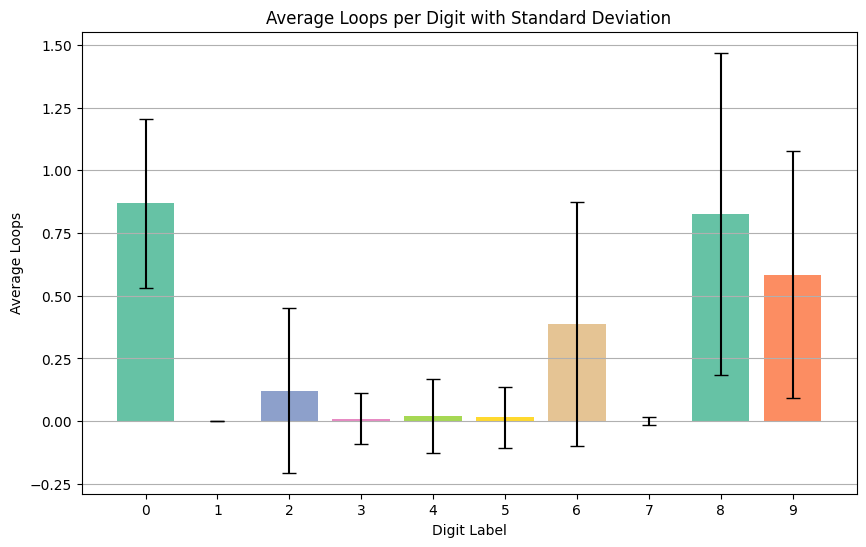

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
average_loops = np.zeros(10)
std_deviation = np.zeros(10)

loops = np.array([count_loops_with_blobs(row) for row in digits])
# Calculate average loops and standard deviation for each digit
for i in range(10):
    digit_loops = loops[labels == i]
    print(digit_loops)
    average_loops[i] = np.mean(digit_loops)
    std_deviation[i] = np.std(digit_loops)

palette = sns.color_palette("Set2", 10)

plt.figure(figsize=(10, 6))
bars = plt.bar(np.arange(10), average_loops, color=palette, yerr=std_deviation, capsize=5)
plt.xlabel('Digit Label')
plt.ylabel('Average Loops')
plt.title('Average Loops per Digit with Standard Deviation')
plt.xticks(np.arange(10))
plt.grid(axis='y')
plt.show()

First lets calculate performance on ink feature alone (normalized):

In [22]:
# Support vecator machine performance
svm = SVC().fit(np.array(custom_train['ink']).reshape(-1, 1), y_train)
svm_ink = svm.score(np.array(custom_test['ink']).reshape(-1, 1), y_test).round(4)
svm_ink

KeyboardInterrupt: 

In [27]:
# Logistic regression performance
logreg = LogisticRegression().fit(np.array(custom_train['ink']).reshape(-1, 1), y_train)
logreg_ink = logreg.score(np.array(custom_test['ink']).reshape(-1, 1), y_test).round(4)
logreg_ink

0.226

,ink,loops
0,-0.459100,1
1,-1.986702,0
2,-0.491612,1
3,-0.273400,0
4,-0.185814,2
...,...,...
36955,1.695139,1
36956,-0.844616,0
36957,-0.041535,0
36958,-1.546228,0


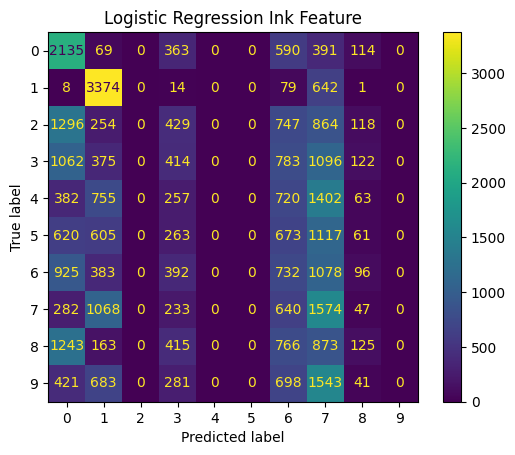

In [31]:
finalLogitPred = logreg.predict(np.array(custom_test['ink']).reshape(-1, 1))
cm = confusion_matrix(y_test, finalLogitPred, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("Logistic Regression Ink Feature")
plt.show()

Now lets add our custom feature - number of loops detected in the image

In [ ]:
# Support Vecator Machine performance
svm = SVC().fit(custom_train, y_train)
svm_loops = svm.score(custom_test, y_test).round(4)
svm_loops

0.3219

In [32]:
# Logistic Regression performance
logreg = LogisticRegression().fit(custom_train, y_train)
logreg_loops = logreg.score(custom_test, y_test).round(4)
logreg_loops

0.3105

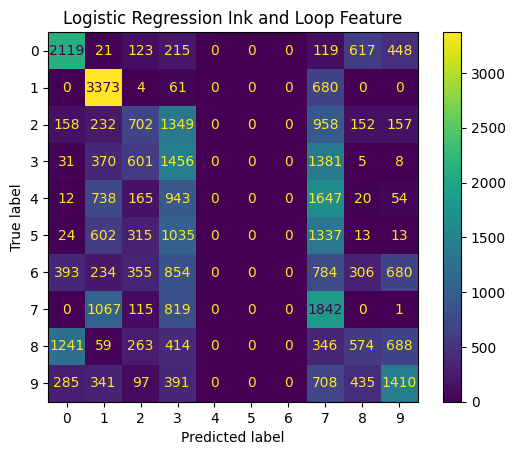

In [34]:
finalLogitPred = logreg.predict(custom_test)
cm = confusion_matrix(y_test, finalLogitPred, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("Logistic Regression Ink and Loop Feature")
plt.show()

Now we'll add another feature set - amount of ink in 4 quarters of the image (also normalized)

In [35]:
def quatro_ink(digits):
  qs = [[] for i in range(4)]
  for d in digits:
   d = d.reshape((28, 28))
   q1 = d[0:7, 0:7].sum()
   q2 = d[7:, 0:7].sum()
   q3 = d[0:7, 7:].sum()
   q4 = d[7:, 7:].sum()
   qs[0].append(q1)
   qs[1].append(q2)
   qs[2].append(q3)
   qs[3].append(q4)
  qs_df = pd.DataFrame(data={'q1': qs[0], 'q2': qs[1], 'q3': qs[2], 'q4': qs[3]})
  return qs_df

scaler4 = StandardScaler()
custom_train = custom_train.join(quatro_ink(x_train))
custom_test = custom_test.join(quatro_ink(x_test))
custom_train[['q1', 'q2', 'q3', 'q4']] = scaler4.fit_transform(custom_train[['q1', 'q2', 'q3', 'q4']])
custom_test[['q1', 'q2', 'q3', 'q4']] = scaler4.transform(custom_test[['q1', 'q2', 'q3', 'q4']])

In [ ]:
# Support Vecator Machine performance
svm = SVC().fit(custom_train, y_train)
svm_loops_qs = svm.score(custom_test, y_test).round(4)
svm_loops_qs

0.5228

In [36]:
# Logistic Regression performance
logreg = LogisticRegression().fit(custom_train, y_train)
logreg_loops_qs = logreg.score(custom_test, y_test).round(4)
logreg_loops_qs

0.4944

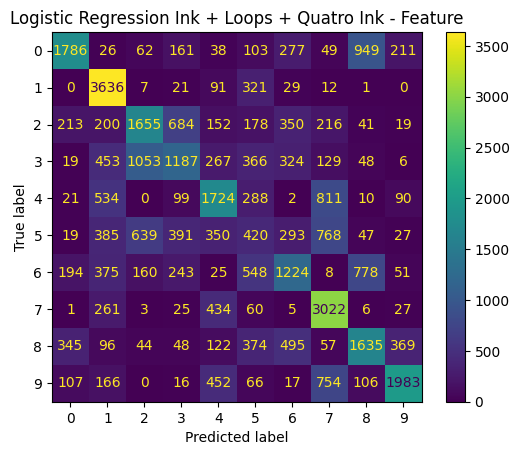

In [37]:
finalLogitPred = logreg.predict(custom_test)
cm = confusion_matrix(y_test, finalLogitPred, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("Logistic Regression Ink + Loops + Quatro Ink - Feature")
plt.show()

Add projection features

In [38]:
def projection_features(digits, direction='vertical'):
    projections = []
    center = 14  # The center of the 28x28 image
    for d in digits:
        d = d.reshape((28, 28))
        if direction == 'vertical':
            weights = np.abs(np.arange(28) - center)
            projection = (d * weights[:, None]).sum()
        else:  # horizontal
            weights = np.abs(np.arange(28) - center)
            projection = (d * weights[None, :]).sum()
        projections.append(projection)
    return pd.DataFrame(data={f'{direction}_projection': projections})

# Add the new features to the training and testing sets
custom_train = custom_train.join(projection_features(x_train, 'vertical'))
custom_train = custom_train.join(projection_features(x_train, 'horizontal'))
custom_test = custom_test.join(projection_features(x_test, 'vertical'))
custom_test = custom_test.join(projection_features(x_test, 'horizontal'))

# Scale the new features
scaler = StandardScaler()
custom_train[['vertical_projection', 'horizontal_projection']] = scaler.fit_transform(custom_train[['vertical_projection', 'horizontal_projection']])
custom_test[['vertical_projection', 'horizontal_projection']] = scaler.transform(custom_test[['vertical_projection', 'horizontal_projection']])

In [ ]:
custom_train

,ink,loops,q1,q2,q3,q4,vertical_projection,horizontal_projection
0,-0.899574,0,-0.159445,-0.598016,-0.929427,-0.719478,-0.509336,-0.625798
1,-0.657759,0,-0.159445,-0.598016,0.032301,-0.682460,-0.560643,-0.665085
2,0.267040,0,-0.159445,2.865295,-0.302719,-0.094150,-0.359526,1.353037
3,0.906520,0,-0.159445,-0.598016,-1.300379,1.516951,1.023981,-0.080562
4,0.421732,0,-0.159445,-0.598016,0.653725,0.435480,0.676747,-0.144681
...,...,...,...,...,...,...,...,...
5035,0.263685,0,-0.159445,-0.598016,-1.300379,0.755205,-0.163025,0.142619
5036,-0.460951,0,-0.159445,-0.558878,-0.704319,-0.264844,-0.747604,-0.500052
5037,0.424046,0,-0.159445,0.521809,-1.300379,0.753011,-0.601663,0.598991
5038,-0.239615,1,-0.159445,-0.598016,0.406424,-0.284038,-0.521866,-0.244070


In [39]:
#Add the projection features to the training and testing sets

svm = SVC().fit(custom_train, y_train)
svm_loops_qs_pr = svm.score(custom_test, y_test).round(4)
print(svm_loops_qs_pr)

logreg = LogisticRegression().fit(custom_train, y_train)
logreg_loops_qs_pr = logreg.score(custom_test, y_test).round(4)
print(logreg_loops_qs_pr)

0.6854
0.6606


d:\Programms\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


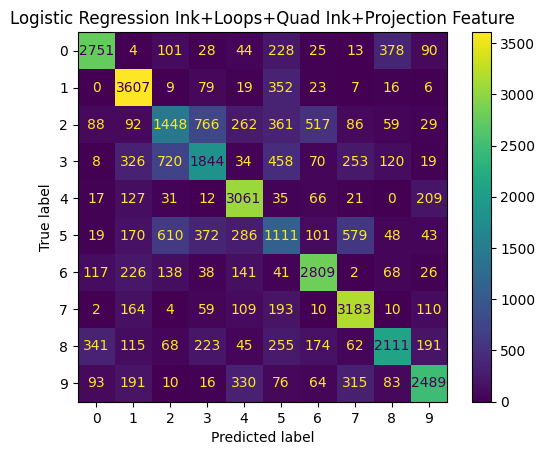

In [40]:
finalLogitPred = logreg.predict(custom_test)
cm = confusion_matrix(y_test, finalLogitPred, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("Logistic Regression Ink+Loops+Quad Ink+Projection Feature")
plt.show()

In [ ]:
comparison_df = pd.DataFrame(data={'model': ['Logistic Regression', 'SVM'],
                                   'ink':[logreg_ink, svm_ink], 'ink+num_loops':[logreg_loops, svm_loops],
                                   'ink+num_loops+quarters_ink':[logreg_loops_qs, svm_loops_qs],
                                   'ink+num_loops+quarters_ink+projections':[logreg_loops_qs_pr, svm_loops_qs_pr]})
comparison_df

,model,ink,ink+num_loops,ink+num_loops+quarters_ink,ink+num_loops+quarters_ink+projections
0,Logistic Regression,0.2260,0.3105,0.4944,0.6606
1,SVM,0.2282,0.3219,0.5228,0.6854


In [ ]:
#Fit the models with pairs of features separately, ink + loops, ink + qs, ink + projections
svm = SVC().fit(custom_train[['ink', 'loops']], y_train)
svm_ink_loops = svm.score(custom_test[['ink', 'loops']], y_test).round(4)
print(svm_ink_loops)

logreg = LogisticRegression().fit(custom_train[['ink', 'loops']], y_train)
logreg_ink_loops = logreg.score(custom_test[['ink', 'loops']], y_test).round(4)
print(logreg_ink_loops)

svm = SVC().fit(custom_train[['ink', 'q1', 'q2', 'q3', 'q4']], y_train)
svm_ink_qs = svm.score(custom_test[['ink', 'q1', 'q2', 'q3', 'q4']], y_test).round(4)
print(svm_ink_qs)

logreg = LogisticRegression().fit(custom_train[['ink', 'q1', 'q2', 'q3', 'q4']], y_train)
logreg_ink_qs = logreg.score(custom_test[['ink', 'q1', 'q2', 'q3', 'q4']], y_test).round(4)
print(logreg_ink_qs)

svm = SVC().fit(custom_train[['ink', 'vertical_projection', 'horizontal_projection']], y_train)
svm_ink_pr = svm.score(custom_test[['ink', 'vertical_projection', 'horizontal_projection']], y_test).round(4)
print(svm_ink_pr)

logreg = LogisticRegression().fit(custom_train[['ink', 'vertical_projection', 'horizontal_projection']], y_train)
logreg_ink_pr = logreg.score(custom_test[['ink', 'vertical_projection', 'horizontal_projection']], y_test).round(4)
print(logreg_ink_pr)



0.3219
0.3105
0.4451
0.4233
0.4573
0.448


In [ ]:
#Make a df for the pairs of features
comparison_df = pd.DataFrame(data={'model': ['Logistic Regression', 'SVM'],
                                   'ink+num_loops':[logreg_ink_loops, svm_ink_loops],
                                   'ink+quarters_ink':[logreg_ink_qs, svm_ink_qs],
                                   'ink+projections':[logreg_ink_pr, svm_ink_pr]})
comparison_df

,model,ink+num_loops,ink+quarters_ink,ink+projections
0,Logistic Regression,0.3105,0.4233,0.4480
1,SVM,0.3219,0.4451,0.4573


### Downsampling image

In [12]:
#Donwsampling of data
def max_pooling_torch(digits, pool_size=2, stride=2, padding=0):
    digits_reshaped = digits.reshape(-1, 1, 28, 28)
    digits_tensor = torch.tensor(digits_reshaped, dtype=torch.float32)

    max_pool = nn.MaxPool2d(kernel_size=pool_size, stride=stride, padding=padding)
    pooled_digits = max_pool(digits_tensor)
    pooled_digits = pooled_digits.view(pooled_digits.size(0), -1)

    pooled_digits = pooled_digits.numpy()

    return pooled_digits

x_train_pooled = max_pooling_torch(x_train)
x_test_pooled = max_pooling_torch(x_test)

<h3>Regularized multinomial logit model (using the LASSO penalty).</h3>

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

The logistic regression classifier by default applies L2 (Ridge) regularisation using the lbfgs solver. The liblinear and the saga solver, support both L1 (Lasso) and L2 regularisation. Liblinear is used for one vs rest schemes, which is appropriate for digit classification. We initially explored the differences between the two solvers, and found that saga seemed to perform better, to validate this we added it to as a hyperparameter.

<h3>Initial Exploration</h3>

In [ ]:
logitClf = LogisticRegression(random_state=0, penalty="l1", solver="saga").fit(x_train,y_train)
logitClfLib = LogisticRegression(random_state=0, penalty="l1", solver="liblinear").fit(x_train,y_train)

In [ ]:
logitClf.score(x_train,y_train)

In [ ]:
logitClfLib.score(x_train,y_train)

<h3>K-Fold Cross Validation for Hyperparameter Tuning</h3>

We apply 5-fold cross validation to our models, and tune hyperparameters until the we hit diminishing returns (i.e not mutch change in mean cross validation error).
In a first round of hyperparameter tuning we used Cross Validation Grid search to apply 5-fold cross validation to all possible combinations of chosen parameters. The first round we tested five possible values for C [0.1,0.5,1,1.5,2] with the saga solver over 25 fits. The best fit was found at C=0.5

In a second round, we added the solver as a hyperparameter with two options liblinear and saga and tested the following C values [0.3,0.4,0.5,0.6,0.7]. Where the best fit was present at 0.3 with the saga solver. (total of 50 fits) Yielding a crossvalidation accuracy of 88.6%

In a third round we tested the C-values [0.1,0.15,0.2,0.25,0.3,0.35] Here C=0.2 yielded the best result, which was rounded to 88.65, marginally better than for C=3. So we stopped tuning. And chose parameters C=0.2 and solver=saga.


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= 17)

In [ ]:

#Grid Search for parameter
#test 1 params = {'C': [0.1,0.5,1,1.5,2]}
#test 2 params = {'C':  [0.3,0.4,0.5,0.6,0.7],'solver':["saga",'liblinear']}

params = {'C':  [0.1,0.15,0.2,0.25,0.3,0.35]}

best_logitComposition = GridSearchCV(estimator=logitClf, param_grid=params,
                              cv= skf, verbose= True, n_jobs=-1)

best_logitComposition.fit(x_train, y_train)

In [ ]:
best_logitComposition.best_params_

In [ ]:
best_logitComposition.best_score_

<h3>SVM Hyperparameter tuning</h3>
We use the same approach for hyperparameter tuning for the SVM, tuning using a 5-fold cross validation, tweaking the C value until we hit diminishing returns.

Test 1: {'C':[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,1,1.5,2]} best C=2, cv accuracy: 0.886

Test 2: {'C':[1.5,1.7,1.9,2,2.2,2.4,2.5,2.8,3.0]} best {'C': 3} cv accuracy 0.955

Test 3: {'C':[3.0,3.5,4.0,4.5,5,5.5]} best {'C': 3.5} cv accuarcy 0.9561507936507937 (marginally better than Test 2 so we stop tuning)

Adding Hyperparameters Kernel and Gamma

Test 4: {'C':[1,3.0,3.5,4],'gamma':[1,"scale", "auto"], "kernel":["linear","poly","rbf","sigmoid"]}

In [ ]:
svmClf = SVC(gamma=1).fit(x_train,y_train)

In [ ]:
svmClf.score(x_test,y_test)

0.11141774891774892

In [ ]:
#test 1: params = {'C':[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,1,1.5,2]}
#test 2: params = {'C':[1.5,1.7,1.9,2,2.2,2.4,2.5,2.8,3.0]}
#params = {'C':[3.0,3.5,4.0,4.5,5,5.5]}
params= {'C':[1,3.0,3.5,4],'gamma':[1,"scale", "auto"], "kernel":["linear","poly","rbf","sigmoid"]}
best_svmComposition = GridSearchCV(estimator=svmClf, param_grid=params,
                              cv= skf, verbose= True, n_jobs=-1)

best_svmComposition.fit(x_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             estimator=SVC(gamma=1), n_jobs=-1,
             param_grid={'C': [1, 3.0, 3.5, 4], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=True)

In [ ]:
best_svmComposition.best_params_

{'C': 3.5, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
best_svmComposition.best_score_

0.9561507936507937

<h3>Model Comparison</h3>

In the previous step we have determined the best values for hyperparameter C, which for both the LogisticRegression Classifier and the SupportVector Classifier signifies the inverse regularisation strenght, using a grid parameter search over a 5 fold cross validation. Smaller values, specify stronger regularisation. For the LogisticRegression Classifier we additionally determined the best solver.  

We continue with the following parameters:
LogisticRegression: C=0.2, solver=saga
SVC: C=3.5

<h4>Final Logistic Model</h4>

In [21]:
finalLogitClf = LogisticRegression(random_state=0, C=0.2, penalty="l1", solver="saga").fit(x_train,y_train)

d:\Programms\Anaconda\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [20]:
finalLogitClf.score(x_test,y_test)

ValueError: X has 784 features, but LogisticRegression is expecting 196 features as input.

In [19]:
finalLogitPred = finalLogitClf.predict(x_test)
cm = confusion_matrix(y_test, finalLogitPred, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("Logistic Regression, saga solver with L1 regularisation, C=0.2")
plt.show()

ValueError: X has 784 features, but LogisticRegression is expecting 196 features as input.

<h4>Final SVM Model</h4>

In [17]:
finalSvmClf = SVC(gamma='scale',C=3.5,kernel='rbf').fit(x_train,y_train)

In [18]:
finalSvmClf.score(x_test,y_test)

0.9566017316017316

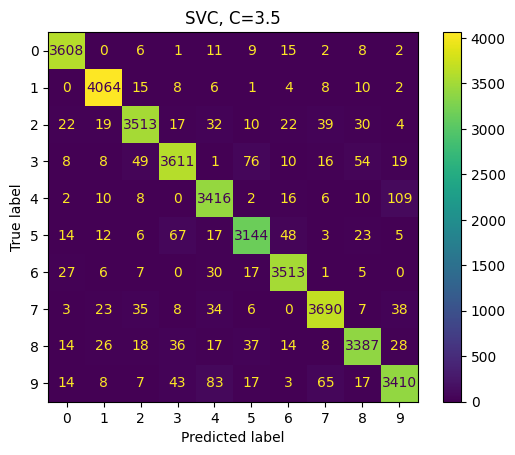

In [ ]:
finalSvmPred = finalSvmClf.predict(x_test)
cm = confusion_matrix(y_test, finalSvmPred, labels=[0,1,2,3,4,5,6,7,8,9])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
disp.plot()
plt.title("SVC, C=3.5")
plt.show()

<h3>Evaluation</h3>
The results are in. For the SVM classifier we achieve accuracies of 95.7%  95.5 on downsampled data, on the test set.
For the Logistic Classifier we achieve 89.0% 88.3 on downsampled data accuracy.

Now we check whether the differences are significant.

We are following the recommendations of Dietterichs 1998 paper on statistical testing for classification, and performing both the
paired 5x2CV test, and McNemar test. The 5x2CV test is recommended for our scenario using two efficient classifiers, while McNemar is more suitable for in cases
where many fits are not possible because of excessive trainig times (large DNNs).

Paired ttest 5x2cv
t statistic: 31.291
p value: 0.000

McNeimar test:
[[34255   157]
 [ 2215   333]]

Model1 Logit, Model2 SVM,
chi-squared: 1783.8317875210791
p-value: 0.0


Interpretation: Results are highly significant.

In [ ]:
from mlxtend.evaluate import paired_ttest_5x2cv


t, p = paired_ttest_5x2cv(estimator1=finalSvmClf,
                          estimator2=finalLogitClf,
                          X=digits, y=labels,
                          random_seed=1)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
d:\Programms\Python\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the co

t statistic: 31.291
p value: 0.000


In [ ]:
import numpy as np
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar

#Create McNemar Contingency matrix (2x2)
tb = mcnemar_table(y_target=y_test,
                   y_model1=finalLogitPred,
                   y_model2=finalSvmPred)


print(tb)

chi2, p = mcnemar(ary=tb, exact=False, corrected=False)
print('chi-squared:', chi2)
print('p-value:', p)


[[34255   157]
 [ 2215   333]]
chi-squared: 1785.566610455312
p-value: 0.0


In [ ]:
# Example of calculating the mcnemar test 2
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table
table = [[34255, 157],
 [2215, 333]]
# calculate mcnemar test
result = mcnemar(table, exact=False)
# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))

statistic=1783.832, p-value=0.000
